# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np

from os.path import join
import json
import datetime

import shap
from shap_selection import feature_selection

from sklearn.preprocessing import OneHotEncoder
import time

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams
from src.plots.functions import plot_3d_surface
from src.optimization.functions import opt_value

# if we want to create an iteractive plot or not
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

## Arrhythmia

**Dataset source**: http://odds.cs.stonybrook.edu/arrhythmia-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources**:

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. “Isolation forest.” 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.

K. M. Ting, J. T. S. Chuan, and F. T. Liu. “Mass: A New Ranking Measure for Anomaly Detection.“, IEEE Transactions on Knowledge and Data Engineering, 2009.

F. Keller, E. Muller, K. Bohm.“HiCS: High-contrast subspaces for density-based outlier ranking.” ICDE, 2012.

In [5]:
dataset_id = 'arrhythmia'

data = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)
data.shape

(452, 275)

In [6]:
pd.pivot_table(data,
             values = 'Col1',
               index = 'y', 
              aggfunc = 'count')

,Col1
y,
0,386
1,66


In [7]:
excluded_cols = ['Col15', 'Col63', 'Col65', 'Col79', 'Col127', 'Col128','Col135', 'Col137', 'Col139','Col141','Col147', 'Col152', 'Col153', 'Col160', 'Col200', 'Col260', 'Col270']

### iForest

## Parameters

In [8]:
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

df = pd.read_parquet(path_shap)

df.head()

,n_estimators,max_feats,contamination,n_feats,n_iter,n_iter_fs,roc_auc,model_stab,model_stab_list,shap_stab,shap_stab_list,shap_stab_ad,f1_median,recall,precision,confusion_matrix
0,1,2,0.117,8,1,1,0.586725,0.998827,"[[0.0, 2.1114671336849542e-10, 4.1302871096460...","[0.9999999998560619, 1.0, 0.8482738758087583, ...","[[0.0, 5.757523881239478e-10, 0.0, 0.0, 0.0, 0...","[0.9999999998920465, 0.9999999998920465, 0.999...",0.181818,0.192308,0.172414,1
1,1,3,0.117,8,1,1,0.622581,0.678238,"[[0.0005460940951908106, 2.44252030089044e-12,...","[1.0, 0.9119035976612363, 0.7709847986851182, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[0.9999999998920465, 0.8531780906355251, 0.848...",0.117647,0.076923,0.250000,1
2,1,4,0.117,8,1,1,0.691811,0.794181,"[[0.0004822998380164125, 9.594795093970105e-09...","[0.9999998886300752, 0.9097983473112028, 0.848...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.454796992798...","[0.8909178517028281, 0.999966507839134, 0.8482...",0.266667,0.230769,0.315789,1
3,1,6,0.117,8,1,1,0.522208,0.750685,"[[1.0, 2.282263099486249e-09, 0.00375335068658...","[0.7173443088664401, 0.7862742215381229, 0.848...","[[0.17772206527697795, 0.05781565465629293, 0....","[0.694003555362308, 0.7550428170300026, 0.5423...",0.090909,0.076923,0.111111,1
4,1,8,0.117,8,1,1,0.492184,0.809821,"[[9.33107919601139e-06, 0.025981476451015142, ...","[0.7979048224995294, 0.9116525004155535, 0.732...","[[0.8986762722426171, 7.051497845462646e-10, 0...","[0.7689181718953443, 0.5628603693971861, 0.490...",0.181818,0.153846,0.222222,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_estimators      2640 non-null   int64  
 1   max_feats         2640 non-null   int64  
 2   contamination     2640 non-null   float64
 3   n_feats           2640 non-null   int64  
 4   n_iter            2640 non-null   int64  
 5   n_iter_fs         2640 non-null   int64  
 6   roc_auc           2640 non-null   float64
 7   model_stab        2640 non-null   float64
 8   model_stab_list   2640 non-null   object 
 9   shap_stab         2640 non-null   object 
 10  shap_stab_list    2640 non-null   object 
 11  shap_stab_ad      2640 non-null   object 
 12  f1_median         2640 non-null   float64
 13  recall            2640 non-null   float64
 14  precision         2640 non-null   float64
 15  confusion_matrix  2640 non-null   int64  
dtypes: float64(6), int64(6), object(4)
memory 

In [23]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

fi_shap_all = pd.read_parquet(path_fi_shap)
df = pd.read_parquet(path_shap)

df['shap_q1'] = df['shap_stab'].apply(lambda x: np.percentile(x, 75))
df['shap_q2'] = df['shap_stab'].apply(lambda x: np.percentile(x, 50))
df['shap_q3'] = df['shap_stab'].apply(lambda x: np.percentile(x, 25))

df['shap_ad_q2'] = df['shap_stab_ad'].apply(lambda x: np.percentile(x, 50))

df['shap_mean'] = df['shap_stab'].apply(lambda x: np.mean(x))


#df['shap_stab'] = df['shap_q2']
#df['shap_inestab'] = 1- df['shap_stab']


var = ['n_estimators', 'max_feats', 'n_feats', 'f1_median', 'precision', 'model_stab', 'shap_stab', 'shap_q2', 'shap_mean']
df = df[var]

In [24]:
#df = df[df.n_estimators<=500]

## Optimization

In [25]:
df.sort_values('precision', ascending=False).head(5)

,n_estimators,max_feats,n_feats,f1_median,precision,model_stab,shap_stab,shap_q2,shap_mean
1249,23,119,119,0.653846,0.653846,0.905724,"[0.8299165455414231, 0.7437502478514935, 0.796...",0.751933,0.756614
1362,25,91,152,0.612245,0.652174,0.905024,"[0.7905115742633889, 0.7371513854764253, 0.729...",0.724851,0.729193
1139,21,119,119,0.627451,0.640000,0.902499,"[0.8154546533789765, 0.7316937820399084, 0.799...",0.746476,0.752197
1084,20,119,119,0.627451,0.640000,0.900374,"[0.8194645410777276, 0.7257240761094341, 0.801...",0.749568,0.754184
1473,75,121,152,0.583333,0.636364,0.958187,"[0.8825986647664373, 0.7874959264277541, 0.831...",0.815630,0.816375


In [26]:
df.shape

(2640, 9)

In [27]:
sorted_df = opt_value(df, lambda_=0.5, var2='shap_mean')

opt_x = int(sorted_df.iloc[0:1,:].n_estimators)
opt_y = int(sorted_df.iloc[0:1,:].n_feats)

sorted_df

,n_estimators,max_feats,n_feats,f1_median,precision,model_stab,shap_stab,shap_q2,shap_mean,opt_value
2621,600,47,119,0.530612,0.565217,0.989293,"[0.9811823343632802, 0.9658268174611099, 0.976...",0.966787,0.960301,0.762759
2289,450,94,94,0.530612,0.565217,0.988963,"[0.9816813167929569, 0.970766226596047, 0.9624...",0.965154,0.958132,0.761675
2456,525,47,119,0.530612,0.565217,0.988109,"[0.9773131845397197, 0.9624837732783608, 0.975...",0.963247,0.956803,0.761010
2401,500,47,119,0.530612,0.565217,0.987730,"[0.9786528881047648, 0.9660652556284971, 0.968...",0.963436,0.955537,0.760377
2179,400,94,94,0.530612,0.565217,0.988406,"[0.9814381150008675, 0.9704415212203699, 0.961...",0.962449,0.955417,0.760317
...,...,...,...,...,...,...,...,...,...,...
24,1,57,57,0.133333,0.157895,0.544800,"[0.6706995778837086, 0.663704405719329, 0.6865...",0.697977,0.695796,0.426845
138,3,58,73,0.127660,0.142857,0.746119,"[0.6760690414916506, 0.6319364924780309, 0.676...",0.672718,0.674431,0.408644
126,3,16,42,0.125000,0.136364,0.675673,"[0.6681654116791585, 0.6956367433981905, 0.671...",0.672672,0.676922,0.406643
69,2,29,29,0.127660,0.142857,0.725362,"[0.5781395164445167, 0.7292147452620128, 0.667...",0.640334,0.651048,0.396952


## Visualization of the results

In [28]:
# Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
idx = df.groupby(['n_estimators', 'n_feats'])['max_feats'].idxmax()
# Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
df_n_trees = df.loc[idx].reset_index(drop=True)

# Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
idx = df.groupby(['n_estimators', 'max_feats'])['n_feats'].idxmax()
# Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
df_max_feat = df.loc[idx].reset_index(drop=True)

In [29]:
df = df_n_trees.copy()

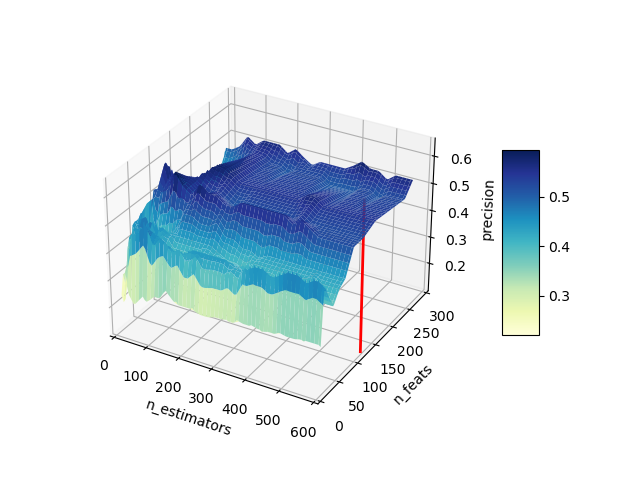

In [30]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'precision', cmap='YlGnBu', x_step=100, y_step=50, opt_x=opt_x, opt_y=opt_y, opt_color='red')


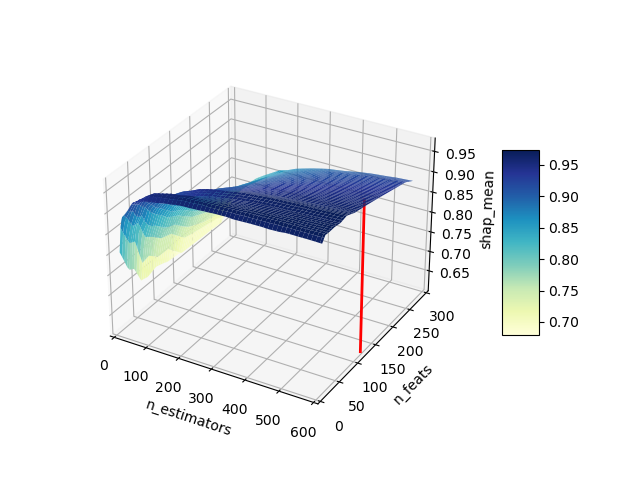

In [31]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'shap_mean', cmap='YlGnBu', x_step=100, y_step=50, opt_x=opt_x, opt_y=opt_y, opt_color='red')

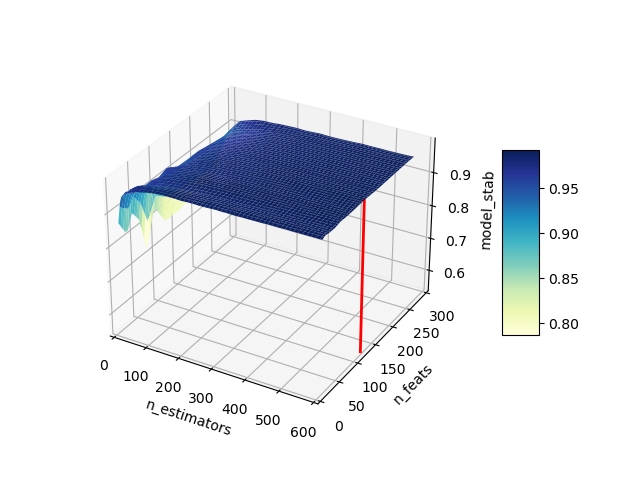

In [32]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'model_stab', cmap='YlGnBu', x_step=100, y_step=50, opt_x=opt_x, opt_y=opt_y, opt_color='red')


In [33]:
df

,n_estimators,max_feats,n_feats,f1_median,precision,model_stab,shap_stab,shap_q2,shap_mean,opt_value
0,1,8,8,0.181818,0.222222,0.809821,"[0.7979048224995294, 0.9116525004155535, 0.732...",0.840082,0.833223,0.527723
1,1,18,18,0.360000,0.375000,0.691301,"[0.7136527295307764, 0.6623040840072614, 0.689...",0.691946,0.702708,0.538854
2,1,29,29,0.088889,0.105263,0.660081,"[0.5715304978311826, 0.6853524395653945, 0.618...",0.599222,0.605910,0.355586
3,1,42,42,0.212766,0.238095,0.780293,"[0.5965787647882749, 0.6984499277171057, 0.681...",0.673422,0.673538,0.455817
4,1,57,57,0.133333,0.157895,0.544800,"[0.6706995778837086, 0.663704405719329, 0.6865...",0.697977,0.695796,0.426845
...,...,...,...,...,...,...,...,...,...,...
523,600,94,94,0.509804,0.520000,0.990988,"[0.9825692335353372, 0.978193077259603, 0.9696...",0.971009,0.964588,0.742294
524,600,119,119,0.509804,0.520000,0.992777,"[0.9785412678858537, 0.963393689140481, 0.9785...",0.967523,0.958943,0.739471
525,600,152,152,0.520000,0.541667,0.989761,"[0.9773528475235337, 0.9602219869106139, 0.960...",0.957844,0.950058,0.745862
526,600,235,235,0.489796,0.521739,0.989786,"[0.9752659551733267, 0.928763503296821, 0.9316...",0.928764,0.926395,0.724067


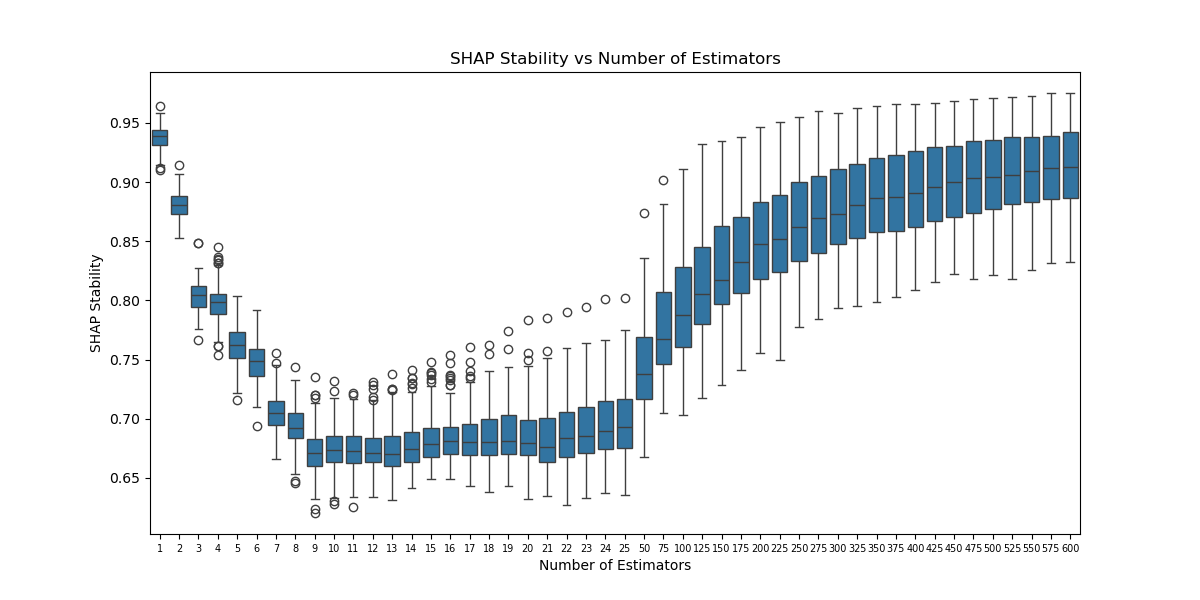

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data simulating the user's dataframe structure.
# For demonstration purposes, we use random data here.
# The user would replace this with their actual dataframe.

# Choosing the row with the highest max_feats and n_feats for each n_estimator
selected_rows = df.sort_values(by=['max_feats', 'n_feats'], ascending=[False, False]).drop_duplicates(['n_estimators'])

# Exploding the list in 'shap_stab' into separate rows.
df_exploded = selected_rows.explode('shap_stab')

# Convert 'shap_stab' to numeric as it might be read as object due to the list.
df_exploded['shap_stab'] = pd.to_numeric(df_exploded['shap_stab'])

# Creating a boxplot with 'n_estimators' on the x-axis and 'shap_stab' values on the y-axis.
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_exploded, x='n_estimators', y='shap_stab')

# Adjusting the size of the x-axis labels
plt.xticks(fontsize=7)

# Additional plot formatting, if necessary
plt.title('SHAP Stability vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('SHAP Stability')
plt.show()
